<a href="https://colab.research.google.com/github/ahmadalideeb/Autoencoder/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!pip3 install scipy==1.1.0

In [ ]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Autoencoders')

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val:

In [ ]:
X_train = data[0:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:]

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

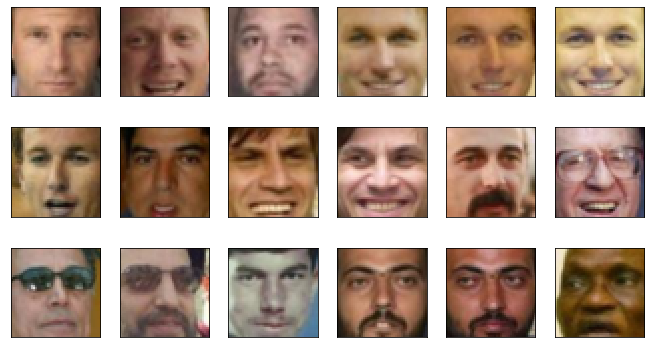

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [ ]:
from copy import deepcopy
from torchvision.transforms import ToTensor


X_train_copy=deepcopy(X_train)
X_val_copy=deepcopy(X_val)

X_train_copy = torch.Tensor(X_train_copy)

In [ ]:
X_train=torch.FloatTensor(X_train)
X_val=torch.FloatTensor(X_val)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [ ]:
inp_size=6075 #X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
#####
#Network architecture for vanilla autoencoder without convolution layers
#####

class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder_hidden_layer = nn.Linear(
          in_features=inp_size, out_features=256
      )
      self.encoder_output_layer = nn.Linear(
          in_features=256, out_features=dim_code
      )
      self.decoder_hidden_layer = nn.Linear(
          in_features=dim_code, out_features=256
      )
      self.decoder_output_layer = nn.Linear(
          in_features=256, out_features=inp_size
      )
        
    def forward(self, x):
      activation = self.encoder_hidden_layer(x)
      activation = torch.relu(activation)
      latent_code = self.encoder_output_layer(activation)
      latent_code = torch.relu(latent_code)
      activation = self.decoder_hidden_layer(latent_code)
      activation = torch.relu(activation)
      activation = self.decoder_output_layer(activation)
      reconstruction = torch.relu(activation)
        
      return reconstruction, latent_code

In [ ]:
#####
#Network architecture for vanilla autoencoder with convolution layers
#####

class Autoencoder1(nn.Module):
    def __init__(self):
      super().__init__()

      self.encoder_conv = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
          #nn.BatchNorm2d(16),
          nn.LeakyReLU(),
          nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
          #nn.BatchNorm2d(32),
          nn.LeakyReLU(),
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
          #nn.BatchNorm2d(64),
          nn.LeakyReLU()
      )

      self.encoder_linear=nn.Sequential(
          nn.Linear(64*6*6, 100)
      )

      self.decoder_a=nn.Sequential(
          nn.Linear(100, 64*6*6)
      )

      self.decoder_b = nn.Sequential(
          nn.LeakyReLU(),
          nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
          nn.LeakyReLU(),
          nn.ConvTranspose2d(32, 16,3, stride=2, padding=1),
          nn.LeakyReLU(),
          nn.ConvTranspose2d(16, 3,3, stride=2, padding=1)
          )

    def encod (self,x):
      x=self.encoder_conv(x)
      x=x.reshape(-1, 64*6*6)
      latent_code=self.encoder_linear(x)
      return latent_code
      
    def decod (self,x):
      x=self.decoder_a(x)
      x=x.reshape(-1, 64, 6,6)
      reconstruction=self.decoder_b(x)
      return reconstruction
    
    def auto_encode(self,x):
      latent_code=self.encod(x)
      reconstruction=self.decod(latent_code)
      return reconstruction, latent_code

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()

vanilla_autoencoder = Autoencoder1().to(device)

optimizer = optim.Adam(vanilla_autoencoder.parameters(), lr=1e-3)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
epochs=150
batch_size=32
X_train_Loader=DataLoader(X_train, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    loss = 0
    for batch_features in X_train_Loader:
        # load it to the active device and make permute so the convolution layers can deal with it
        batch_features=batch_features.permute(0,3,1,2).to(device)        
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs,_ = vanilla_autoencoder.auto_encode(batch_features.float())

        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features.float())
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(X_train_Loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/150, loss = 2004.241751
epoch : 2/150, loss = 658.912901
epoch : 3/150, loss = 531.973911
epoch : 4/150, loss = 470.234789
epoch : 5/150, loss = 413.939881
epoch : 6/150, loss = 341.921721
epoch : 7/150, loss = 275.017802
epoch : 8/150, loss = 250.947860
epoch : 9/150, loss = 231.554974
epoch : 10/150, loss = 223.375986
epoch : 11/150, loss = 223.410686
epoch : 12/150, loss = 206.139303
epoch : 13/150, loss = 220.523205
epoch : 14/150, loss = 190.645346
epoch : 15/150, loss = 183.932827
epoch : 16/150, loss = 194.784143
epoch : 17/150, loss = 182.728735
epoch : 18/150, loss = 176.053706
epoch : 19/150, loss = 168.057087
epoch : 20/150, loss = 167.148645
epoch : 21/150, loss = 171.590899
epoch : 22/150, loss = 173.227923
epoch : 23/150, loss = 159.132175
epoch : 24/150, loss = 154.192646
epoch : 25/150, loss = 153.167053
epoch : 26/150, loss = 148.446704
epoch : 27/150, loss = 143.469955
epoch : 28/150, loss = 154.753467
epoch : 29/150, loss = 149.851637
epoch : 30/150, loss =

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

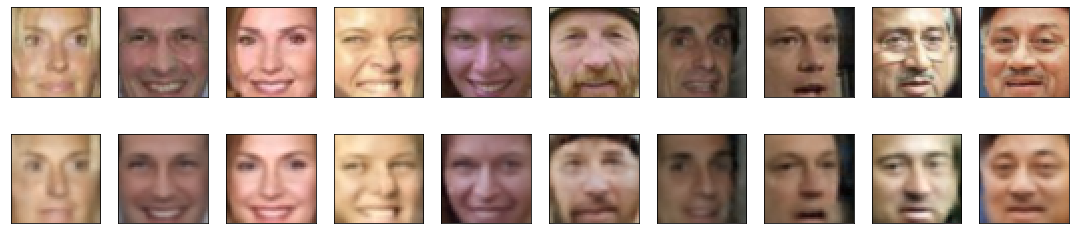

In [ ]:
X_val_temp=deepcopy(X_val)
X_val_temp=X_val_temp.permute(0,3,1,2).to(device)
reconstruction,latent=vanilla_autoencoder.auto_encode(X_val_temp.float())

reconstruction = reconstruction.permute(0,2,3,1)
origin = X_val[10:20]
reconstruction = reconstruction.type(torch.FloatTensor)[10:20]

origin_with_reconstruction = torch.cat((origin, reconstruction), 0)
origin_with_reconstruction=torch.clamp(origin_with_reconstruction,0,255)
origin_with_reconstruction=origin_with_reconstruction.type(torch.uint8)

plot_gallery(origin_with_reconstruction, IMAGE_H, IMAGE_W,n_row=2,n_col=10)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

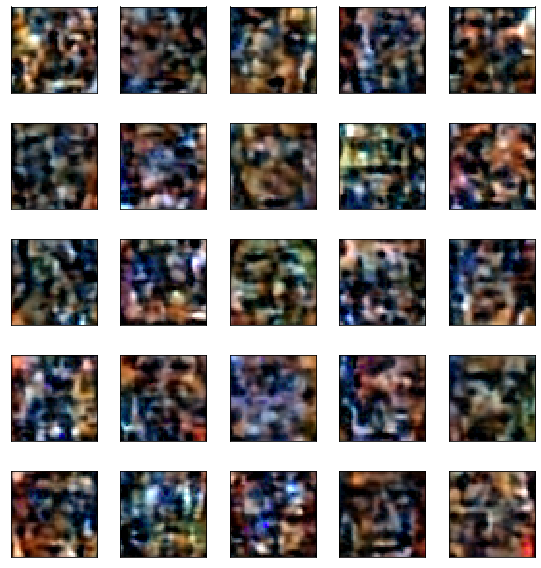

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 100)
z=torch.FloatTensor(z).to(device)
z=latent.std()*z+latent.mean()

sampled_output = vanilla_autoencoder.decod(z)
sampled_output=sampled_output.permute(0,2,3,1)
sampled_output=sampled_output.type(torch.FloatTensor)
sampled_output=torch.clamp(sampled_output,0,255)
sampled_output=sampled_output.type(torch.uint8)

plot_gallery(sampled_output, IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smile_values=attrs.Smiling

smile_values=smile_values.to_numpy()

happy_smile=np.where(smile_values>2.5)
sad_smile=np.where(smile_values<-2.4)

happy_smile_index=happy_smile[0][happy_smile[0]<10000][0:20]
sad_smile_index=sad_smile[0][sad_smile[0]<10000][0:20]

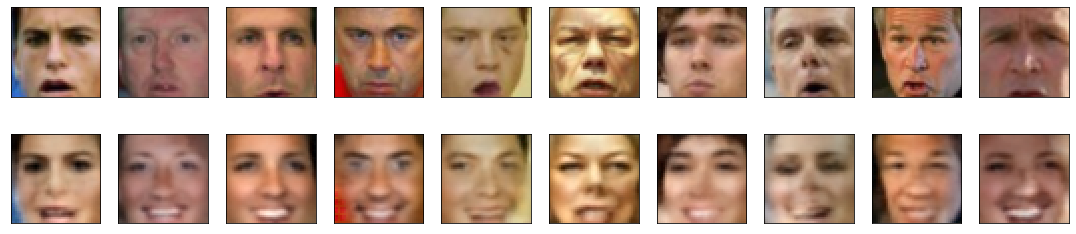

In [ ]:
happy_smile_images = X_train[happy_smile_index]
sad_smile_images = X_train[sad_smile_index]

happy_smile_latent = deepcopy(happy_smile_images)
sad_smile_latent = deepcopy(sad_smile_images)

happy_smile_latent = happy_smile_latent.permute(0,3,1,2).to(device) 
sad_smile_latent = sad_smile_latent.permute(0,3,1,2).to(device)

happy_smile_latent = vanilla_autoencoder.encod(happy_smile_latent.float())
sad_smile_latent = vanilla_autoencoder.encod(sad_smile_latent.float())

smile = torch.mean(happy_smile_latent,dim=0) - torch.mean(sad_smile_latent,dim=0)

sad_add_smile_images = vanilla_autoencoder.decod(sad_smile_latent+smile)

sad_add_smile_images=sad_add_smile_images.permute(0,2,3,1)

sad=sad_smile_images[0:10]
happy=sad_add_smile_images.type(torch.FloatTensor)[0:10]

sad_happy = torch.cat((sad, happy), 0)
sad_happy=torch.clamp(sad_happy,0,255)
sad_happy=sad_happy.type(torch.uint8)

plot_gallery(sad_happy, IMAGE_H, IMAGE_W,n_row=2,n_col=10)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        '''
        
        self.encoder_conv = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
          #nn.BatchNorm2d(16),
          nn.LeakyReLU(),
          nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
          #nn.BatchNorm2d(32),
          nn.LeakyReLU(),
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
          #nn.BatchNorm2d(64),
          nn.LeakyReLU()
      )
        
        self.encoder_mu=nn.Sequential(
          nn.Linear(64*6*6, 100)
      )
        
        self.encoder_logsigma=nn.Sequential(
          nn.Linear(64*6*6, 100)
      )
        
        self.decoder_a=nn.Sequential(
          nn.Linear(100, 64*6*6)
      )
        
        self.decoder_b = nn.Sequential(
          nn.LeakyReLU(),
          nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
          nn.LeakyReLU(),
          nn.ConvTranspose2d(32, 16,3, stride=2, padding=1),
          nn.LeakyReLU(),
          nn.ConvTranspose2d(16, 3,3, stride=2, padding=1),
          nn.Sigmoid()
          )
        

    def encode(self, x):
        '''
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>
        '''
        x=self.encoder_conv(x)
        x=x.reshape(-1, 64*6*6)
        mu=self.encoder_mu(x)
        logsigma=self.encoder_logsigma(x)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        '''
        <реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction>
        '''      
        z=self.decoder_a(z)
        z=z.reshape(-1, 64, 6,6)
        reconstruction=self.decoder_b(z)
        
        return reconstruction


    def forward(self, x):
        '''
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        '''
        mu , logsigma = self.encode (x)
        z = self.gaussian_sampler(mu , logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss_method=nn.BCELoss()
    loss=loss_method(reconstruction, x)
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return ((KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction))).mean()

И обучим модель:

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = loss_vae

variational_autoencoder = VAE().to(device)

optimizer = optim.Adam(variational_autoencoder.parameters(), lr=1e-3)

In [ ]:
epochs=20
batch_size=32
X_train_Loader=DataLoader(X_train_copy, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    loss=0
    for batch_features in X_train_Loader:
        # load it to the active device
        batch_features=batch_features.permute(0,3,1,2).to(device)        
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        #divide by 255 so the input of BCE will be between 0 and 1
        batch_features/=255
        # compute reconstructions
        mu,logsigma,reconstruction = variational_autoencoder.forward(batch_features)

        
        # compute training reconstruction loss
        train_loss = criterion(batch_features, mu, logsigma, reconstruction)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(X_train_Loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/20, loss = 18.028096
epoch : 2/20, loss = 0.691515
epoch : 3/20, loss = 0.693189
epoch : 4/20, loss = 0.699186
epoch : 5/20, loss = 0.699100
epoch : 6/20, loss = 0.696588
epoch : 7/20, loss = 0.700982
epoch : 8/20, loss = 0.707716
epoch : 9/20, loss = 0.692176
epoch : 10/20, loss = 0.682825
epoch : 11/20, loss = 0.668998
epoch : 12/20, loss = 0.653602
epoch : 13/20, loss = 0.644316
epoch : 14/20, loss = 0.638056
epoch : 15/20, loss = 0.634003
epoch : 16/20, loss = 0.631697
epoch : 17/20, loss = 0.628723
epoch : 18/20, loss = 0.627391
epoch : 19/20, loss = 0.634236
epoch : 20/20, loss = 0.625110


In [ ]:
#torch.save(autoencoder.state_dict(), '/content/gdrive/My Drive/VAE/autoencoder1')

In [ ]:
####
# This model has been trained and saved before on around 4000 epoch
####
variational_autoencoder.load_state_dict(torch.load('/content/gdrive/My Drive/VAE/autoencoder'))
variational_autoencoder.eval()

VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (encoder_mu): Sequential(
    (0): Linear(in_features=2304, out_features=100, bias=True)
  )
  (encoder_logsigma): Sequential(
    (0): Linear(in_features=2304, out_features=100, bias=True)
  )
  (decoder_a): Sequential(
    (0): Linear(in_features=100, out_features=2304, bias=True)
  )
  (decoder_b): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Con

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

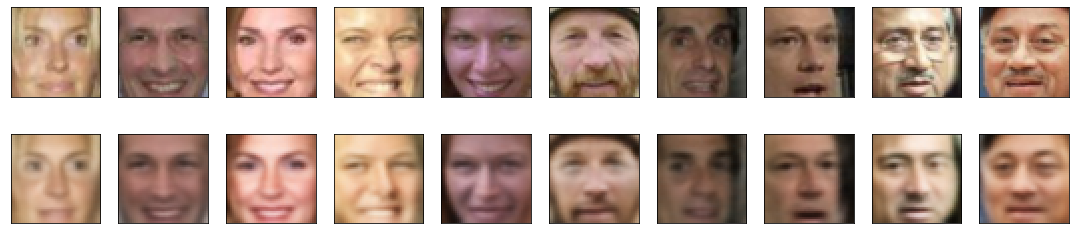

In [ ]:
X_val_temp=deepcopy(X_val)
X_val_temp=X_val_temp.permute(0,3,1,2).to(device)

X_val_temp/=255
mu,logsigma,reconstruction=variational_autoencoder.forward(X_val_temp)

reconstruction=reconstruction.permute(0,2,3,1)#.to(device)
origin=X_val[10:20]
reconstruct=reconstruction.type(torch.FloatTensor)[10:20]
reconstruct*=255

origin_reconstruct = torch.cat((origin, reconstruct), 0)
origin_reconstruct = torch.clamp(origin_reconstruct,0,255)
origin_reconstruct = origin_reconstruct.type(torch.uint8)

plot_gallery(origin_reconstruct, IMAGE_H, IMAGE_W,n_row=2,n_col=10)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

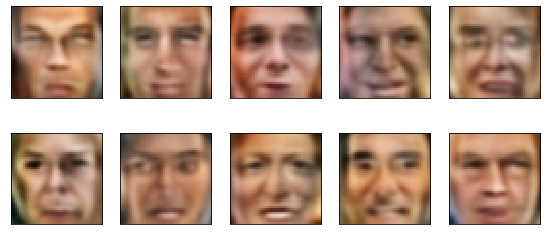

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
mu,logsigma,reconstruction=variational_autoencoder.forward(X_train_copy.permute(0,3,1,2).to(device)/255)

with torch.no_grad():
  z = np.array([np.random.normal(mu.mean().cpu().detach().numpy(), mu.std().cpu().detach().numpy(), 100) for i in range(10)])

  z = torch.FloatTensor(z).to(device)

  sampled_output = variational_autoencoder.decode(z)
  sampled_output*=255
  sampled_output=sampled_output.permute(0,2,3,1)
  sampled_output=sampled_output.type(torch.LongTensor)
  sampled_output=torch.clamp(sampled_output,0,255)

  plot_gallery(sampled_output, IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
gender_values=attrs.Male
gender_values=gender_values.to_numpy()

female_index=np.where(gender_values<0)
male_index=np.where(gender_values>0)

test_image_female_index=female_index[0][female_index[0]>10000]
test_image_male_index=male_index[0][male_index[0]>10000]

In [ ]:
mu,logsigma,reconstruction=variational_autoencoder.forward(X_val_temp)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(mu.detach().cpu().numpy())

In [ ]:
tsne.shape

(3143, 2)

Text(0.5, 1.0, 'Distribution of Females')

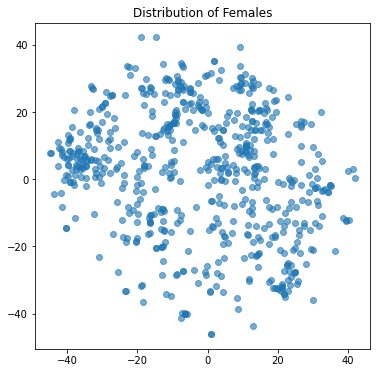

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(tsne[test_image_female_index-10000,0],tsne[test_image_female_index-10000,1],alpha=0.6)
plt.title("Distribution of Females")

Text(0.5, 1.0, 'Distribution of Males')

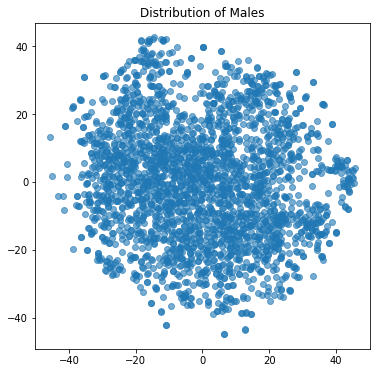

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(tsne[test_image_male_index-10000,0],tsne[test_image_male_index-10000,1],alpha=0.6)
plt.title("Distribution of Males")

Text(0.5, 1.0, 'Distribution of Genders')

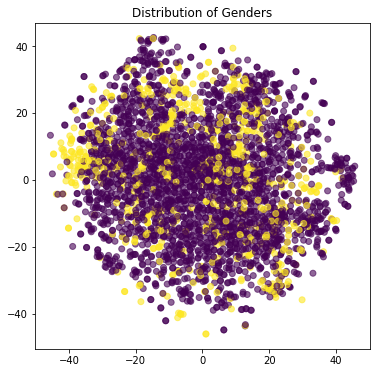

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(tsne[:,0],tsne[:,1],c=attrs['Male'][10000:]<0,alpha=0.6)
plt.title("Distribution of Genders")

Что вы думаете о виде латентного представления?

I think that the males in the dataset are more than the females so I think that the model will be biased to males when generating random samples and even in reconstruction that may cause to reconstruct female faces with males attributes.

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
attrs_vec=deepcopy(attrs)
attrs_vec=attrs_vec.to_numpy()

attrs_vec[attrs_vec>0]=1
attrs_vec[attrs_vec<0]=0

attrs_vec=attrs_vec.astype(None)
attrs_vec[0]

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0.])

In [ ]:
attrs_vec=torch.FloatTensor(attrs_vec)
attrs_vec=attrs_vec.to(device)

attrs_train_vec=attrs_vec[:10000]
attrs_val_vec=attrs_vec[10000:]

In [ ]:
input_size=45*45*3
attrs_size=73
latent_size=100

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        '''
        
        self.encoder = nn.Sequential(
          nn.Linear(input_size + attrs_size, 1024),
          nn.LeakyReLU(),
          nn.Linear(1024, 256),
          nn.LeakyReLU()
      )
        
        self.encoder_mu=nn.Sequential(
          nn.Linear(256, 100)
      )
        
        self.encoder_logsigma=nn.Sequential(
          nn.Linear(256, 100)
      )
        
        self.decoder=nn.Sequential(
          nn.Linear(latent_size + attrs_size, 256),
          nn.LeakyReLU(),
          nn.Linear(256, 1024),
          nn.LeakyReLU(),
          nn.Linear(1024, input_size),
          nn.Sigmoid()
      )
        

    def encode(self, x, cond):
        '''
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>
        '''
        x=x.reshape(-1, input_size)
        input=torch.cat([x, cond], 1)
        input=self.encoder(input)
        mu=self.encoder_mu(input)
        logsigma=self.encoder_logsigma(input)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z, cond):
        '''
        <реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction>
        '''
        z=torch.cat([z, cond], 1)
        reconstruction=self.decoder(z)
        reconstruction=reconstruction.reshape(-1, 45, 45,3)
        return reconstruction


    def forward(self, x, cond):
        '''
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        '''
        mu , logsigma = self.encode (x, cond)
        z = self.gaussian_sampler(mu , logsigma)
        reconstruction = self.decode(z, cond)
        return mu, logsigma, reconstruction

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = loss_vae

conditional_autoencoder = CVAE().to(device)

optimizer = optim.Adam(conditional_autoencoder.parameters(), lr=1e-3)

In [ ]:
epochs=40
batch_size=128
X_train_Loader=DataLoader(X_train_copy, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    loss=0
    for i , batch_features in enumerate(X_train_Loader):
        # reshape mini-batch data to [N, 45*45*3] matrix
        # load it to the active device
        #batch_features = batch_features.view(-1, IMAGE_H*IMAGE_W*3).to(device)
        batch_features = batch_features.to(device)
        #batch_features=batch_features.permute(0,3,1,2).to(device)        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        batch_features/=255
        #print(batch_features.max())
        # compute reconstructions
        mu,logsigma,reconstruction = conditional_autoencoder.forward(batch_features.to(device),attrs_train_vec[i*batch_size:(i+1)*batch_size].to(device))
        #print(reconstruction.max())

        # compute training reconstruction loss
        train_loss = criterion(batch_features, mu, logsigma, reconstruction)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(X_train_Loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/40, loss = 886.345032
epoch : 2/40, loss = 2.952969
epoch : 3/40, loss = 1.758211
epoch : 4/40, loss = 1.429636
epoch : 5/40, loss = 1.280667
epoch : 6/40, loss = 1.312395
epoch : 7/40, loss = 13.098137
epoch : 8/40, loss = 1.740878
epoch : 9/40, loss = 1.227566
epoch : 10/40, loss = 22.476864
epoch : 11/40, loss = 1.686207
epoch : 12/40, loss = 1.120600
epoch : 13/40, loss = 1.024255
epoch : 14/40, loss = 1.060846
epoch : 15/40, loss = 3.449500
epoch : 16/40, loss = 1.347614
epoch : 17/40, loss = 10.713264
epoch : 18/40, loss = 1.489962
epoch : 19/40, loss = 0.959557
epoch : 20/40, loss = 1.086173
epoch : 21/40, loss = 2.021618
epoch : 22/40, loss = 6.195818
epoch : 23/40, loss = 1.234165
epoch : 24/40, loss = 0.980510
epoch : 25/40, loss = 9.589013
epoch : 26/40, loss = 1.153447
epoch : 27/40, loss = 0.892316
epoch : 28/40, loss = 0.898216
epoch : 29/40, loss = 5.294612
epoch : 30/40, loss = 1.018438
epoch : 31/40, loss = 1.063122
epoch : 32/40, loss = 2.342518
epoch : 33/4

In [ ]:
torch.save(conditional_autoencoder.state_dict(), '/content/gdrive/My Drive/VAE/CVAE')

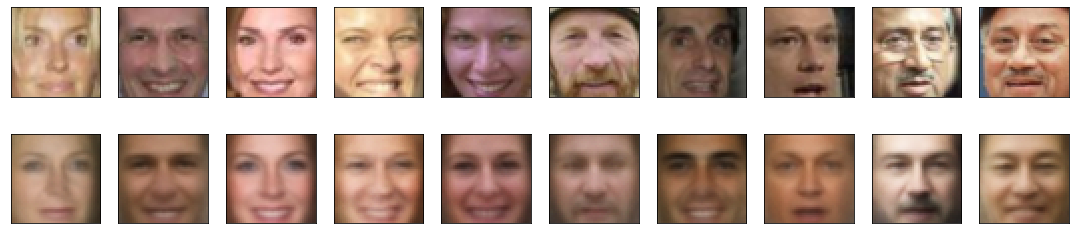

In [ ]:
X_val_temp=deepcopy(X_val)
X_val_temp=X_val_temp.to(device)

X_val_temp/=255
mu,logsigma,reconstruction=conditional_autoencoder.forward(X_val_temp,attrs_val_vec)

origin = X_val[10:20]
reconstruct = reconstruction.type(torch.FloatTensor)[10:20]
reconstruct*=255

origin_reconstruct = torch.cat((origin, reconstruct), 0)
origin_reconstruct=torch.clamp(origin_reconstruct,0,255)
origin_reconstruct=origin_reconstruct.type(torch.uint8)

plot_gallery(origin_reconstruct, IMAGE_H, IMAGE_W,n_row=2,n_col=10)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
attrs.head(2)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559



 first person  :  white+mustache 
 second person :  sunglasses+smiling 
 third person  :  black+bald


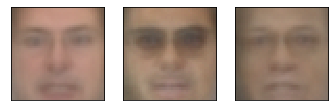

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(-3.5830e-06, 0.00020345, 100) for i in range(3)])

z=torch.FloatTensor(z).to(device)
cond=np.zeros((3,73))
# First person
cond[0][0]=1   # First person to be male
cond[0][2]=1   # First person to be white
cond[0][16]=1  # First person with mustache

# Second person
cond[1][0]=1   # Second person to be male
cond[1][15]=1   # Second person with sunglasses
cond[1][17]=1  # Second person smiling

# Third person
cond[2][0]=1   # Second person to be male
cond[2][3]=1   # Second person to be black
cond[2][12]=1  # Second person to be bald

cond=torch.FloatTensor(cond).to(device)

output = conditional_autoencoder.decode(z.to(device), cond)
output*=255
output=output.type(torch.FloatTensor)
output=torch.clamp(output,0,255)
output=output.type(torch.uint8)
print("\n first person  :  white+mustache \n second person :  sunglasses+smiling \n third person  :  black+bald")
plot_gallery(output, IMAGE_H, IMAGE_W, n_row=1, n_col=3)


Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
mu,logsigma,reconstruction=conditional_autoencoder.forward(X_val_temp,attrs_val_vec)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(mu.detach().cpu().numpy())
tsne.shape

(3143, 2)

Text(0.5, 1.0, 'Distribution of Females')

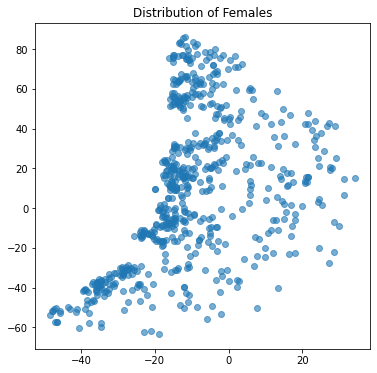

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(tsne[test_image_female_index-10000,0],tsne[test_image_female_index-10000,1],alpha=0.6)
plt.title("Distribution of Females")

Text(0.5, 1.0, 'Distribution of Males')

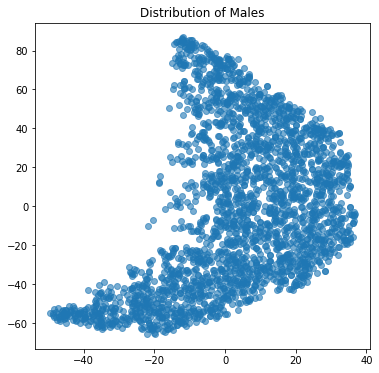

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(tsne[test_image_male_index-10000,0],tsne[test_image_male_index-10000,1],alpha=0.6)
plt.title("Distribution of Males")

Text(0.5, 1.0, 'Distribution of Genders')

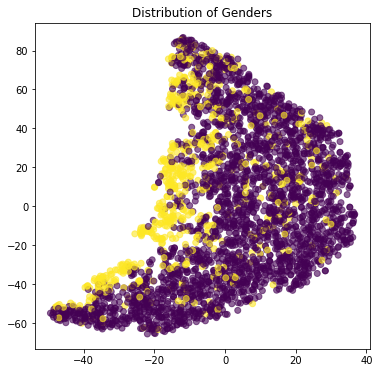

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(tsne[:,0],tsne[:,1],c=attrs['Male'][10000:]<0,alpha=0.6)
plt.title("Distribution of Genders")

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Here there is a difference in distribution between VAE and CVAE because the latent space in CVAE got influenced by the conditional vector that entered to the encoder.

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
X_val_temp=deepcopy(X_val)
X_val_temp=X_val_temp.permute(0,3,1,2).to(device)
X_val_result,latent=autoencoder.auto_encode(X_val_temp.float())

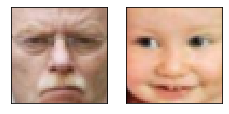

In [ ]:
X_val_temp=X_val_temp.permute(0,2,3,1).to(device)
X_val_temp=X_val_temp.type(torch.LongTensor)
plot_gallery([X_val_temp[90].numpy(),X_val_temp[224].numpy()], IMAGE_H, IMAGE_W,n_row=1,n_col=2)

In [ ]:
result=torch.FloatTensor()
result=result.to(device)
for i in np.arange(0.0,1.1,0.1):
  image=i*latent[90]+(1-i)*latent[224]
  image=image.unsqueeze(0)
  result=torch.cat((image,result),0)

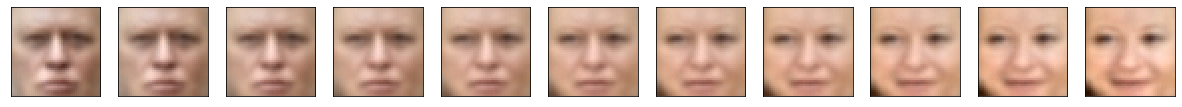

In [ ]:
result_images = autoencoder.decod(result)

result_images=result_images.permute(0,2,3,1)

result_images=result_images.type(torch.FloatTensor)

result_images=torch.clamp(result_images,0,255)
result_images=result_images.type(torch.uint8)

plot_gallery(result_images, IMAGE_H, IMAGE_W,n_row=1,n_col=11)


# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
X_train_no_noise = deepcopy(X_train)
X_val_no_noise = deepcopy(X_val)

In [ ]:
noise_factor = 0.5
X_train_noisy = X_train_no_noise + 255*noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_no_noise.shape)
X_val_noisy = X_val_no_noise + 255*noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val_no_noise.shape) 

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

denoising_autoencoder = Autoencoder1().to(device)

optimizer = optim.Adam(denoising_autoencoder.parameters(), lr=1e-3)

In [ ]:
epochs=50
batch_size=32
X_train_Loader=DataLoader(X_train_noisy, batch_size=batch_size, shuffle=False)
for epoch in range(epochs):
    loss = 0
    for i, batch_features in enumerate(X_train_Loader):
        # load it to the active device
        batch_features=batch_features.permute(0,3,1,2).to(device)        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs,_ = denoising_autoencoder.auto_encode(batch_features.float())

        original_images=X_train_no_noise[i*batch_size:(i+1)*batch_size]
        original_images=original_images.permute(0,3,1,2).to(device)

        # compute training reconstruction loss
        train_loss = criterion(outputs, original_images.float())
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(X_train_Loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/50, loss = 270.360404
epoch : 2/50, loss = 274.862292
epoch : 3/50, loss = 275.531489
epoch : 4/50, loss = 269.349118
epoch : 5/50, loss = 265.785747
epoch : 6/50, loss = 255.371093
epoch : 7/50, loss = 245.841947
epoch : 8/50, loss = 239.603464
epoch : 9/50, loss = 237.423264
epoch : 10/50, loss = 234.529698
epoch : 11/50, loss = 229.415686
epoch : 12/50, loss = 226.305937
epoch : 13/50, loss = 223.287815
epoch : 14/50, loss = 221.270698
epoch : 15/50, loss = 219.525972
epoch : 16/50, loss = 218.264449
epoch : 17/50, loss = 217.343599
epoch : 18/50, loss = 217.144400
epoch : 19/50, loss = 219.938214
epoch : 20/50, loss = 236.166187
epoch : 21/50, loss = 239.455076
epoch : 22/50, loss = 244.636084
epoch : 23/50, loss = 251.433439
epoch : 24/50, loss = 265.799581
epoch : 25/50, loss = 290.077671
epoch : 26/50, loss = 258.284925
epoch : 27/50, loss = 246.590221
epoch : 28/50, loss = 244.297185
epoch : 29/50, loss = 257.818091
epoch : 30/50, loss = 279.370351
epoch : 31/50, loss

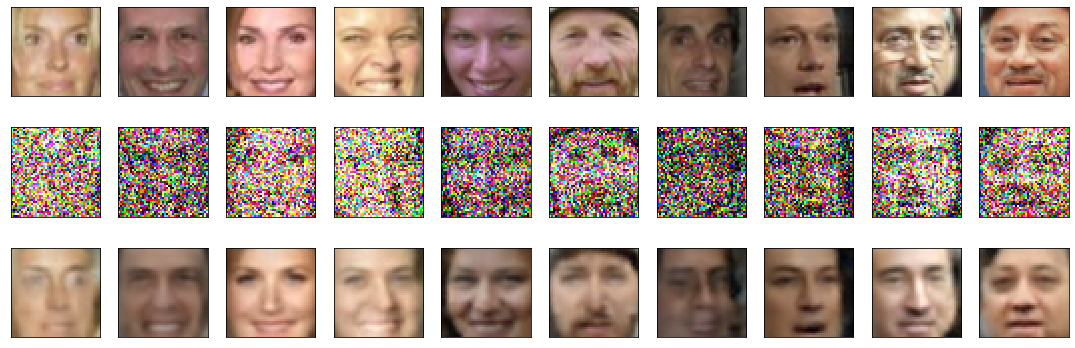

In [ ]:
X_val_temp=deepcopy(X_val_noisy)
X_val_temp=X_val_temp.permute(0,3,1,2).to(device)
X_val_result,latent=denoising_autoencoder.auto_encode(X_val_temp.float())

X_val_result=X_val_result.permute(0,2,3,1)
original = X_val[10:20]
original_with_noise=X_val_noisy.type(torch.FloatTensor)[10:20]
reconstruct=X_val_result.type(torch.FloatTensor)[10:20]

third_tensor = torch.cat((original_with_noise, reconstruct), 0)
third_tensor = torch.cat((original, third_tensor), 0)
third_tensor=torch.clamp(third_tensor,0,255)
third_tensor=third_tensor.type(torch.uint8)

plot_gallery(third_tensor, IMAGE_H, IMAGE_W,n_row=3,n_col=10)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
X_train_no_occlusion = deepcopy(X_train)
X_val_no_occlusion = deepcopy(X_val)

In [ ]:
from torchvision.transforms import RandomErasing

erase=RandomErasing(p=1,scale=(0.04,0.04),ratio=(1,1),value=0)
X_train_occluded = torch.FloatTensor()

for i in range(X_train_no_occlusion.shape[0]):
  image=X_train_no_occlusion[i].permute((2,0,1))
  image = erase(image)
  image=image.unsqueeze(0)
  image=image.permute(0,2,3,1)
  X_train_occluded=torch.cat((X_train_occluded,image),0)


In [ ]:
X_val_occluded = torch.FloatTensor()

for i in range(X_val_no_occlusion.shape[0]):
  image=X_val_no_occlusion[i].permute((2,0,1))
  image = erase(image)
  image=image.unsqueeze(0)
  image=image.permute(0,2,3,1)
  X_val_occluded=torch.cat((X_val_occluded,image),0)

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()

occlusion_autoencoder = Autoencoder1().to(device)

optimizer = optim.Adam(occlusion_autoencoder.parameters(), lr=1e-3)

In [ ]:
epochs=40
batch_size=32
X_train_Loader=DataLoader(X_train_occluded, batch_size=batch_size, shuffle=False)
for epoch in range(epochs):
    loss = 0
    for i, batch_features in enumerate(X_train_Loader):
        # load it to the active device
        batch_features=batch_features.permute(0,3,1,2).to(device)        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs,_ = occlusion_autoencoder.auto_encode(batch_features.float())

        original_images=X_train_no_occlusion[i*batch_size:(i+1)*batch_size]
        original_images=original_images.permute(0,3,1,2).to(device)

        # compute training reconstruction loss
        train_loss = criterion(outputs, original_images.float())
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(X_train_Loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/40, loss = 172.436967
epoch : 2/40, loss = 152.516751
epoch : 3/40, loss = 147.001969
epoch : 4/40, loss = 148.066041
epoch : 5/40, loss = 147.939668
epoch : 6/40, loss = 152.678341
epoch : 7/40, loss = 153.799352
epoch : 8/40, loss = 157.652664
epoch : 9/40, loss = 145.221938
epoch : 10/40, loss = 142.441325
epoch : 11/40, loss = 138.224537
epoch : 12/40, loss = 137.219516
epoch : 13/40, loss = 137.947284
epoch : 14/40, loss = 144.659375
epoch : 15/40, loss = 145.343160
epoch : 16/40, loss = 143.078421
epoch : 17/40, loss = 153.060573
epoch : 18/40, loss = 142.152238
epoch : 19/40, loss = 137.902446
epoch : 20/40, loss = 134.213342
epoch : 21/40, loss = 133.723533
epoch : 22/40, loss = 133.591194
epoch : 23/40, loss = 139.235516
epoch : 24/40, loss = 141.376511
epoch : 25/40, loss = 140.747341
epoch : 26/40, loss = 141.632016
epoch : 27/40, loss = 140.236174
epoch : 28/40, loss = 138.804484
epoch : 29/40, loss = 136.573054
epoch : 30/40, loss = 133.263898
epoch : 31/40, loss

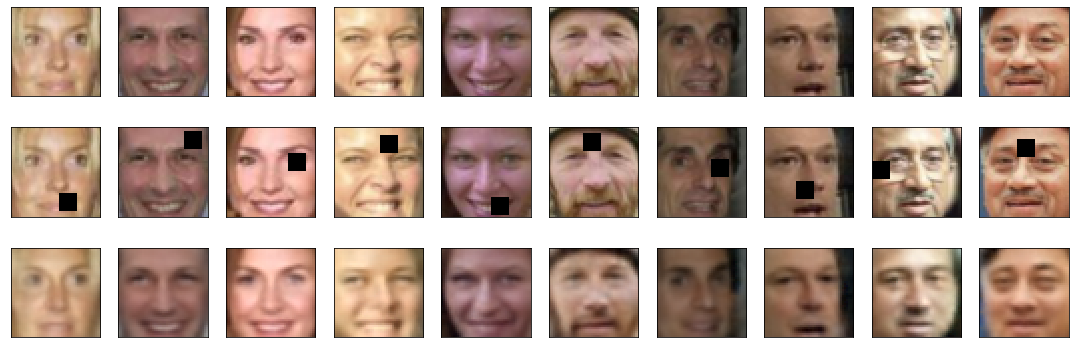

In [ ]:
X_val_temp=deepcopy(X_val_occluded)
X_val_temp=X_val_temp.permute(0,3,1,2).to(device)
X_val_result,latent=occlusion_autoencoder.auto_encode(X_val_temp.float())

X_val_result=X_val_result.permute(0,2,3,1)
original = X_val_no_occlusion[10:20]
original_with_occlusion  = X_val_occluded.type(torch.FloatTensor)[10:20]
reconstruct=X_val_result.type(torch.FloatTensor)[10:20]

third_tensor = torch.cat((original_with_occlusion, reconstruct), 0)
third_tensor = torch.cat((original, third_tensor), 0)
third_tensor=torch.clamp(third_tensor,0,255)
third_tensor=third_tensor.type(torch.uint8)

plot_gallery(third_tensor, IMAGE_H, IMAGE_W,n_row=3,n_col=10)

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
X_train_temp=deepcopy(X_train)
X_train_temp=X_train_temp.permute(0,3,1,2).to(device)

X_train_temp/=255
mu,logsigma,reconstruction=vautoencoder.forward(X_train_temp)

codes = mu

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_neighbors=10).fit(codes.cpu().detach().numpy())

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  image=image.permute(2,0,1).to(device)
  image/=255
  image=image.unsqueeze(0)
  mu,logsigma,reconstruction=vautoencoder.forward(image)
  code = mu
    
  (distances,),(idx,) = NN.kneighbors(code.cpu().detach().numpy(), n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    image=image.type(torch.uint8)
    plt.imshow(image.cpu().numpy())
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].type(torch.uint8).cpu().numpy())
        plt.title("Dist=%.5f"%distances[i])
    plt.show()

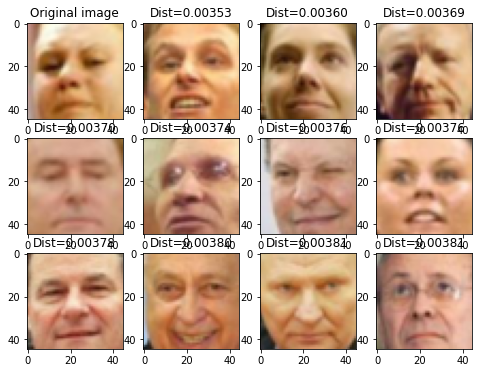

In [ ]:
show_similar(X_val[8])

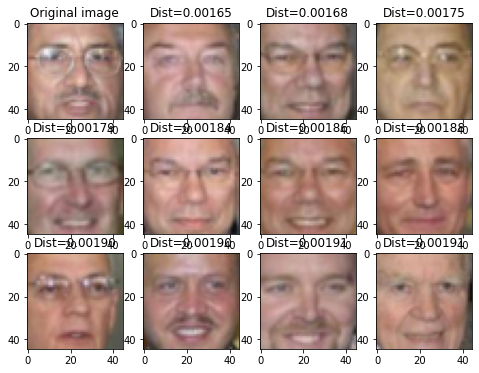

In [ ]:
show_similar(X_val[30])

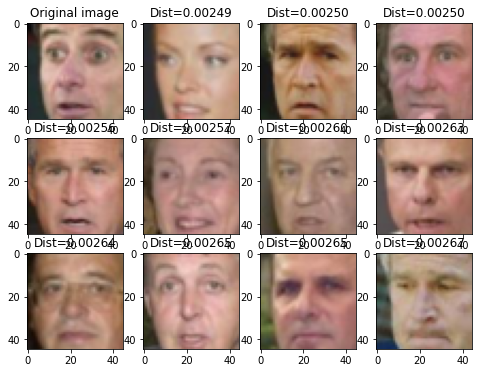

In [ ]:
show_similar(X_val[654])

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!